In [0]:
!pip install -U -q PyDrive
!pip install gensim
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# User authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Providing sharable id's for our files(both .CSV and .sqlite files)
downloaded = drive.CreateFile({'id':'1asnlWHehsHOGpH7-Yz0kFybHTqpZA3mk'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Reviews.csv')
database_file=drive.CreateFile({'id':'1AV74iWjX_KZ4OBx0x7wi6w8G4RL86SM1'})
database_file.GetContentFile('database.sqlite')

In [0]:
# Reading our CSV File
import pandas as pd
df = pd.read_csv('Reviews.csv') 
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


The above dataset shows amazon food reviews which consists of  9 columns and 568454 rows. each feature consists of

---> Product ID,User ID,Profile Name,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text








In [0]:
#importing our required libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import gensim
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
df.shape

(568454, 10)

(no. of rows,no. of columns)



No handles with labels found to put in legend.


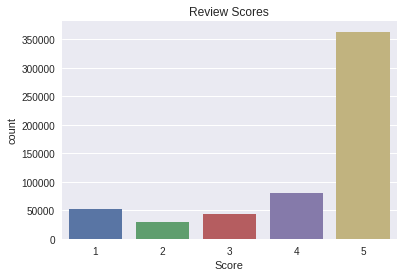

In [0]:
ax=plt.axes()
sns.countplot(df.Score,ax=ax)
ax.set_title('Review Scores')
plt.legend()
plt.show()

Observation: majority of the reviews are rated as 5.
Here, we plotted a count plot which shows the distribution of review scores among the total population

In [0]:
DB_CONNECT = sqlite3.connect('database.sqlite') 
REVIEW_FILTERED = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """,DB_CONNECT)
# here, we are omitting reviews =3 and then returning new dataframe into REVIEW_FILTERED
def polarity(rev):
    if rev<3:
        return 'negative'
    return 'positive'
actualScore = REVIEW_FILTERED['Score'] #score column is copied to actual score
positiveNegative = actualScore.map(polarity)# mapping the column to polarity method and returning strings(positive,negative) 
REVIEW_FILTERED['Score'] = positiveNegative # replacing the columns in our data with positive/negative strings
print(REVIEW_FILTERED.shape) #looking at the number of attributes and size of the data
REVIEW_FILTERED.head(2)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


--->In the above code,  we just ignored the reviews which are valued 3 (as 3 remains neutral which dosent signifies neither positive nor negative review)
--->Also , we just changed the signs of reviews as positive with reviews>3 and negative with reviews<3 

No handles with labels found to put in legend.


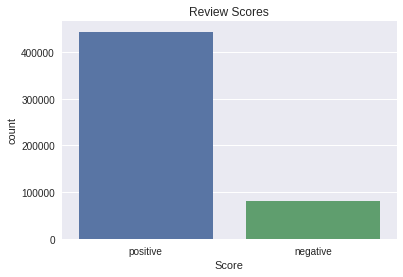

Score
negative     82037
positive    443777
Name: Summary, dtype: int64

In [0]:
ax=plt.axes()
sns.countplot(REVIEW_FILTERED.Score,ax=ax)
ax.set_title('Review Scores')
plt.legend()
plt.show()
REVIEW_FILTERED.groupby('Score')['Summary'].count()

Here, we just represented the distributions of positive and negative scores using count plot

Observations: Most of the distributions are positive (>400k points)


# TEXT-PRE-PROCESSING PHASE

In [0]:
rem_dup=REVIEW_FILTERED.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")
rem_dup.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


Every product has unique ProductID but has different colors, hence, when a product is reviewed ,different flavours of same product will also get reviewed at same time. hence , there is need to remove duplicates with same userID,profilename,Time and text

In [0]:
data_reduction=(rem_dup['Id'].size/REVIEW_FILTERED['Id'].size)*100
print(100-data_reduction,'%')

30.741098563370315 %


As we have removed duplicates, there is reduction of data (30.741098563370315 % data comprises of same reviews with same profile-name,same userID at same time stamp)

In [0]:
print(REVIEW_FILTERED.shape)
print(rem_dup.shape)

(525814, 10)
(364173, 10)


After removal of duplicates, our data consistes of 364k rows(original data=525k rows)

In [0]:
df1=rem_dup[rem_dup.HelpfulnessNumerator<=rem_dup.HelpfulnessDenominator]
df1.shape

(364171, 10)

In some rows , HelpfulnessNumerator is greater than HelpfulnessDenominator.... which is impossible....hence, we ignored those rows

Observation: 2 rows has such condition. hence , these couple of rows are removed

In [0]:
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
'''Function for HTML-Tag removal
 we are creating function which removes HTML scripts that present in our text reviews'''
def rem_html_tags(review):
    text=re.compile('<.*?>')# regular expressions that need to be find
    return text.sub('',review) #replace nothing while above tags occur
#Function for Punctuation marks removal
def rem_punctuations(review):
    text=re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return text.sub('',review)
#Now, Intialise stop-words(most-common words which makes of no-value while vectoring)
stop_words=set(stopwords.words('english')) #these are set of stopwords
#Intialise snow-ball stemmer
snow_stem=nltk.stem.SnowballStemmer('english') #returns root of some words
#Now, we just look for pre-processing a single review
str='' # Intializing a string varing variable for updating document step-wise
final_str=[] # we store pre-processed string in this list
str2='' # used as filtered word later
for sentence in df1['Text'][:1].values: # running for very first review
  filtered_sentence=[] # creating a list which we append filtered words later
  print(sentence) # Just for a look up of review 
  html_filtered=rem_html_tags(sentence) # returns HTML-filtered format
  punct_filtered=rem_punctuations(html_filtered) # returns words with no-puctuation marks
  half_filtered=punct_filtered.split() # contains words without HTML & punctuation marks
  print(half_filtered)
  for word in half_filtered: # iterate through each word in review
    print("present word----------------------->",word) 
    if(word.isalpha() and len(word)>2): # checking whether all characters are alphabets and limiting length
      if(word.lower() not in stop_words):
        str2=(snow_stem.stem(word.lower())).encode('utf8') # stemming each and every word
        print('stemmed version----->',str2)
        filtered_sentence.append(str2) # updating our list with stemmed words
      else:
        print(word,"is a stop word")
        continue
    else:
      print(word,"eliminated as it is non-alphabet or length<2")
      continue
  str1 = b" ".join(filtered_sentence) #final string of cleaned words
  final_str.append(str1)
  print("====================================================================")
  print("Finally selected words from the review:\n",final_str)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']
present word-----------------------> I
I eliminated as it is non-alphabet or length<2
present word-----------------------> have
have is a stop word
present word-----------------------> bought
stemmed version-----> b'boug

Here,  we are pre-processing text for a single review and printed intermediate outputs

In [0]:
df1=df1[:5000] # sampling upto 5k points as our dataset is huge for facilitating t-SNE run-time

In [0]:
from time import time
%time
count=0 # intializing counter for iterating through entire rows
str1=''
final_str=[]
pos_words=[] #stores words from positive reviews
neg_words=[] #stores words from negative reviews
str2=''
t0=time()
for sentence in df1['Text'].values: # running for very first review
  filtered_sentence=[] # creating a list which we append filtered words later
  html_filtered=rem_html_tags(sentence) # returns HTML-filtered format
  punct_filtered=rem_punctuations(html_filtered) # returns words with no-puctuation marks
  half_filtered=punct_filtered.split() # contains words without HTML & punctuation marks
  for word in half_filtered: # iterate through each word in review
    if(word.isalpha() and len(word)>2): # checking whether all characters are alphabets and limiting length
      if(word.lower() not in stop_words):
        str2=(snow_stem.stem(word.lower())).encode('utf8') # stemming each and every word
        filtered_sentence.append(str2) # updating our list with stemmed words
        if (df1['Score'].values)[count]=='positive': 
          pos_words.append(str2) #list of all words used to describe positive reviews
        if(df1['Score'].values)[count]=='negative':
          neg_words.append(str2) #list of all words used to describe negative reviews reviews
      else:
        continue
    else:
      continue
  str1 = b" ".join(filtered_sentence) #final string of cleaned words
  final_str.append(str1)
  count+=1
print("text successfully pre-processed")


CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 12.4 µs
text successfully pre-processed


we've successfully pre-processed text for every review present in our dataset

In [0]:
print("length of +ve words",len(pos_words))
print("length of -ve words",len(neg_words))

length of +ve words 146348
length of -ve words 33968


In [0]:
df1['CleanedText']=final_str # adding new column to df1 by adding our filtered reviews
df1['CleanedText']=df1['CleanedText'].str.decode("utf-8")
df1.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...


In [0]:
from collections import Counter
pos = Counter(pos_words) # Counter returns frequencies of elements present in it in the form of dictionary
print("first 20 Common postive words",pos.most_common(20))# this returns the keys which are most frequently occured along with their frequency
neg = Counter(neg_words)
print("first 20 Common negative words",neg.most_common(20))

first 20 Common postive words [(b'like', 1809), (b'tast', 1603), (b'good', 1541), (b'flavor', 1518), (b'love', 1462), (b'great', 1404), (b'use', 1263), (b'one', 1181), (b'product', 1166), (b'tri', 1147), (b'food', 993), (b'coffe', 993), (b'chip', 975), (b'make', 973), (b'get', 831), (b'tea', 788), (b'bag', 740), (b'buy', 721), (b'best', 704), (b'eat', 702)]
first 20 Common negative words [(b'like', 439), (b'tast', 427), (b'product', 392), (b'tri', 277), (b'one', 276), (b'flavor', 262), (b'would', 243), (b'food', 235), (b'use', 230), (b'good', 205), (b'buy', 189), (b'order', 186), (b'get', 177), (b'chip', 177), (b'tea', 176), (b'bag', 175), (b'even', 166), (b'make', 161), (b'box', 155), (b'eat', 154)]


Observation: In both most frequent positive and negative words, top-2 words are ['like','tast']. as these words are unigrams(in BoW) by default, so, if we use bi-grams, there is a possibility of getting 'not' before these key words

In [0]:

conn=sqlite3.connect('df1.sqlite')# connecting df1 to sqlite for further proceedings
c=conn.cursor()
conn.text_factory = str
df1.to_sql('df1', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# VECTORIZATION

# BAG-OF-WORDS

In [0]:
c_vect=CountVectorizer() #INTIALIZATION-this Converts a collection of text documents to a matrix of token counts
vectorized=c_vect.fit_transform(df1['CleanedText'].values) # we are vectorizing our reviews
vectorized

<5000x11560 sparse matrix of type '<class 'numpy.int64'>'
	with 150206 stored elements in Compressed Sparse Row format>

In [0]:
vectorized.shape

(5000, 11560)

In [0]:
print(vectorized)

  (0, 483)	1
  (0, 3809)	1
  (0, 5630)	1
  (0, 919)	2
  (0, 9141)	1
  (0, 6187)	1
  (0, 7837)	1
  (0, 9531)	1
  (0, 5819)	1
  (0, 5924)	1
  (0, 8020)	1
  (0, 4374)	1
  (0, 4051)	1
  (0, 7846)	3
  (0, 3962)	1
  (0, 2987)	1
  (0, 1468)	1
  (0, 11008)	1
  (0, 8886)	1
  (0, 1136)	1
  (1, 8325)	1
  (1, 5250)	1
  (1, 10922)	1
  (1, 3401)	1
  (1, 9776)	1
  :	:
  (4998, 3186)	2
  (4998, 8440)	1
  (4998, 1478)	1
  (4998, 11376)	3
  (4998, 6081)	1
  (4998, 8184)	1
  (4998, 3852)	3
  (4998, 2145)	1
  (4998, 9776)	1
  (4998, 7837)	1
  (4998, 5819)	2
  (4998, 4374)	1
  (4999, 446)	1
  (4999, 8968)	1
  (4999, 5424)	1
  (4999, 4540)	1
  (4999, 5067)	1
  (4999, 8730)	1
  (4999, 11336)	1
  (4999, 9575)	1
  (4999, 9940)	1
  (4999, 3794)	1
  (4999, 7024)	1
  (4999, 4763)	1
  (4999, 4374)	1


In [0]:
polar=df1["Score"]
polar.head()

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object

# t-SNE using Bag of Words

In [0]:
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler(with_mean=False).fit_transform(vectorized)
print(standardized_data.shape)

(5000, 11560)


In [0]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=50, random_state=0).fit_transform(standardized_data)

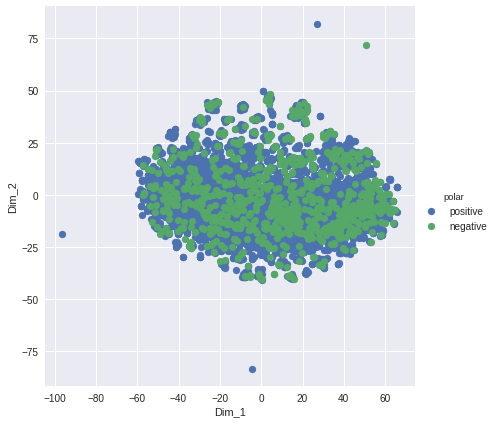

In [0]:
"""
Configuring the parameteres : Default Settings
 the number of components = 2
 perplexity = 30
 learning rate = 200
 Maximum number of iterations for the optimization = 1000
"""
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(tsvd)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,polar)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "polar"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

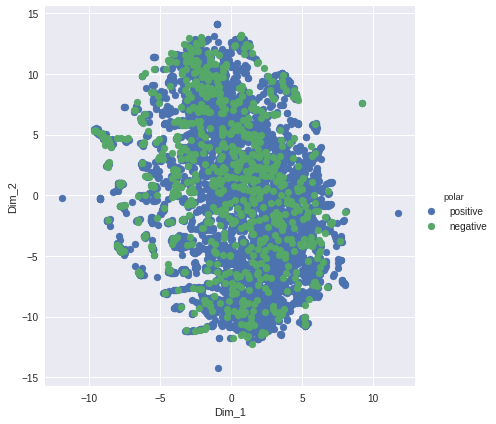

In [0]:
model = TSNE(n_components=2, random_state=0,perplexity=20,n_iter=300)
tsne_data = model.fit_transform(tsvd)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,polar)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "polar"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

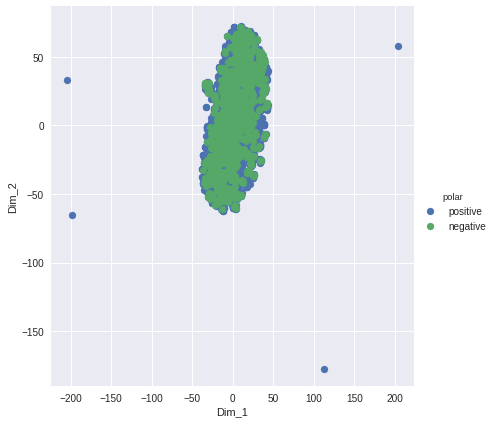

In [0]:
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=5000)
tsne_data = model.fit_transform(tsvd)
tsne_data = np.vstack((tsne_data.T,polar)).T # creating a new data frame which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "polar"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Observations: By using Bag-of-Words , we cant seperate +ve and -ve reviews with manual perplexities and iterations

# t-SNE USING TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer() # intialising TF-IDF Vectorizer
final_tf_idf = tf_idf_vect.fit_transform(df1['CleanedText'].values)
final_tf_idf.shape

(5000, 11560)

In [0]:
standardized_data = StandardScaler(with_mean=False).fit_transform(final_tf_idf) # data standardization

In [0]:
tsvd = TruncatedSVD(n_components=1000, random_state=42).fit_transform(standardized_data) # using truncated SVD for sparse matrices

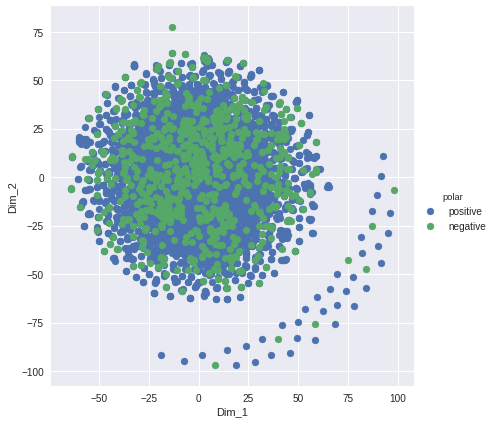

In [0]:
# running t-SNE on TF-IDF vectors
model=TSNE(n_components=2, random_state=0) # fitting values to default perplexity=30, n_iter=1000
tsne_data=model.fit_transform(tsvd)
tsne_data=np.vstack((tsne_data.T,polar)).T # Reducing and transforming dimensions
tsne_df=pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "polar"))
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend() # Ploting the result of tsne
plt.show()

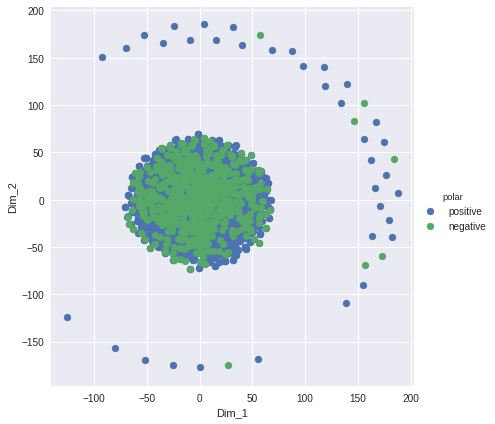

In [0]:
model=TSNE(n_components=2, random_state=0,perplexity=50,n_iter=3000)
tsne_data=model.fit_transform(tsvd)
tsne_data=np.vstack((tsne_data.T, polar)).T
tsne_df=pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "polar"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

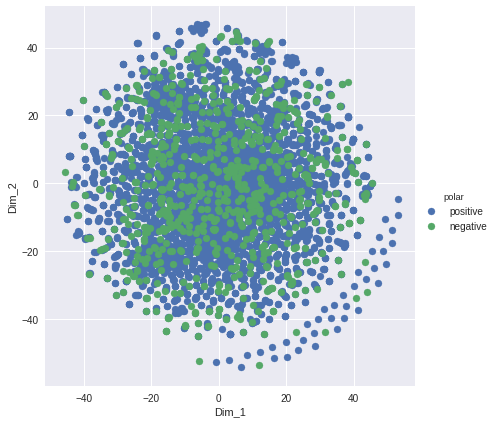

In [0]:
model=TSNE(n_components=2, random_state=0,perplexity=10,n_iter=500)
tsne_data=model.fit_transform(tsvd)
tsne_data=np.vstack((tsne_data.T, polar)).T
tsne_df=pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "polar"))
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()# Ploting the result of tsne
plt.show()

using TF-IDF vectorization, we are not able to seperate +ve and -ve reviews with different combinations of perplexities and iterations

# Word2Vec - Code

In [0]:
# Now,we create and train word-to-vector model on our review set
count=0
sentences=[]
for sentence in df1['CleanedText'].values:
  l1=sentence.split()
  sentences.append(l1)
print(df1['CleanedText'].values[0])
print('=========================================================================================================================================')
print(sentences[0])

bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better
['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


In [0]:

w2v_dict=Word2Vec(sentences,min_count=5,size=50, workers=4)# we are considering the words which occured atleast 5 times, rest of words are of no use
#size is dimentionality of vector corpus
# workers defines no of cores
print(w2v_dict)

Word2Vec(vocab=2934, size=50, alpha=0.025)


vocab is a dictionary of length 2934 (2934 words)

In [0]:
w2v_list=list(w2v_dict.wv.vocab) # converting dictionary into list 
print("number of words that occured minimum 5 times ",len(w2v_list))
print(w2v_list[0:10])

number of words that occured minimum 5 times  2934
['bought', 'sever', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'look']


In [0]:
w2v_dict.wv.most_similar('dog')# most_similar method gives the similar token to the parameter passed

[('food', 0.9922624826431274),
 ('cat', 0.9147171974182129),
 ('newman', 0.8902938961982727),
 ('year', 0.8899030685424805),
 ('eat', 0.8884140849113464),
 ('month', 0.8776780962944031),
 ('organ', 0.8757093548774719),
 ('pet', 0.8592387437820435),
 ('old', 0.8564740419387817),
 ('feed', 0.8558791875839233)]

In [0]:
# computing the avg W2V
sentence_vectors=[]; # for each review,[(W2V(w1)+W2V(w2)+W2V(w3)+....)/n] is stored
for review in sentences: # iterating through each review
    sent_vec=np.zeros(50) # as word vectors are of zero length intially and we took 50 as dimension factor before
    count=0; # num of words with a valid vector in the sentence/review
    for word in review: # for each word in a review/sentence..['dog','eats','food']
        try:
            vec = w2v_dict.wv[word] # converting each word in reviews as vector 
#             print(vec,'.........')
            sent_vec+=vec #adding all values of vectorized words in a document in this numpy array  
            count+=1 # counting no.of words as we need average valued vector
        except:
            pass
    sent_vec=(sent_vec/count) # averaging all values
    sentence_vectors.append(sent_vec) # appending these vectors into our list
print(len(sentence_vectors)) # we will get length of complete avg W2V list for all sentences in reviews (we sampled 5000 reviews)
print(len(sentence_vectors[1])) # we will get length of avg W2V list for one single review/document(50-dimentional as our choice)

5000
50


# t-SNE ON AVG-W2V

In [0]:
standard = StandardScaler().fit_transform(sentence_vectors) # standardising-removing the mean and scaling to unit variance
print(standard.shape)
print(type(standard))

(5000, 50)
<class 'numpy.ndarray'>


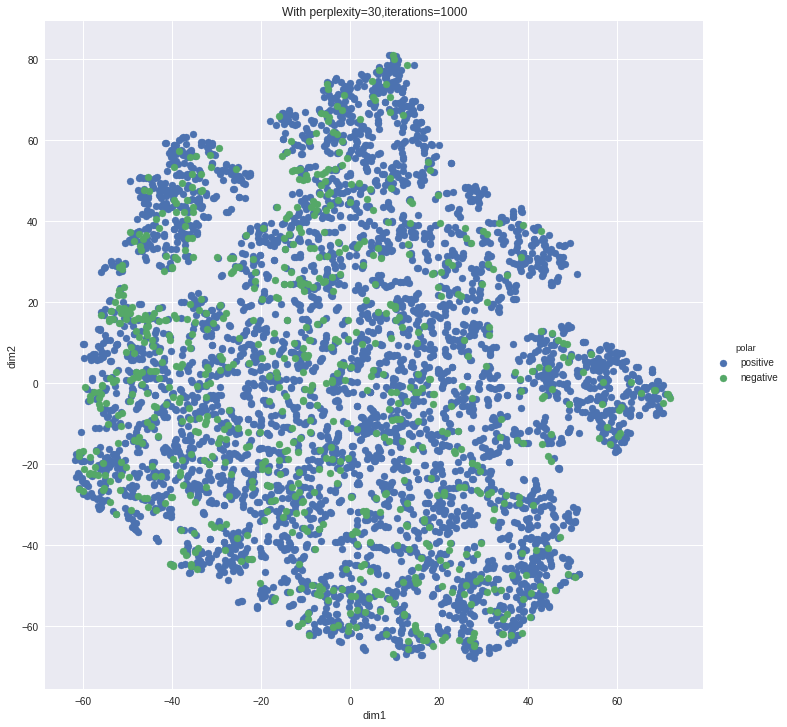

In [0]:
model=TSNE(n_components=2, random_state=0) # intialising tSNE with default values ,perplexity=30, iterations=1000
tsne_data=model.fit_transform(standard)
tsne_data=np.vstack((tsne_data.T, polar)).T # reduction and transformation of dimensions happens in this line
tsne_df=pd.DataFrame(data=tsne_data,columns=("dim1", "dim2", "polar"))
sns.FacetGrid(tsne_df, hue="polar", size=10).map(plt.scatter, 'dim1', 'dim2').add_legend()# Ploting the result of tsne
plt.title('With perplexity=30,iterations=1000')
plt.show()

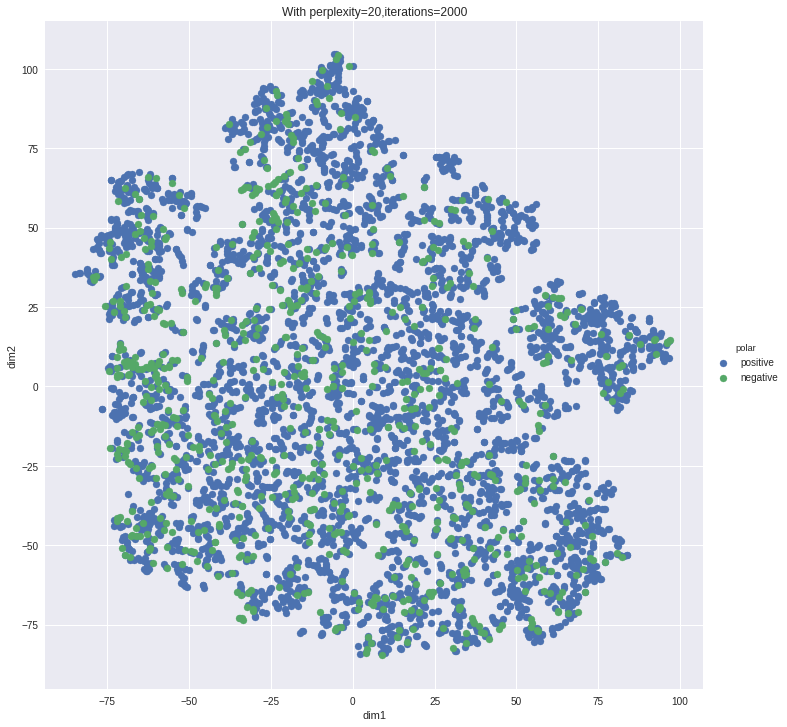

In [0]:
model=TSNE(n_components=2, random_state=0,perplexity=20,n_iter=2000) # intialising tSNE with default values ,perplexity=30, iterations=1000
tsne_data=model.fit_transform(standard)
tsne_data=np.vstack((tsne_data.T, polar)).T # reduction and transformation of dimensions happens in this line
tsne_df=pd.DataFrame(data=tsne_data,columns=("dim1", "dim2", "polar"))
sns.FacetGrid(tsne_df, hue="polar", size=10).map(plt.scatter, 'dim1', 'dim2').add_legend()# Ploting the result of tsne
plt.title('With perplexity=20,iterations=2000')
plt.show()

 even by using avg w2v, the t-SNE plot we build never shows seperation of +ve and -ve reviews

# TF-IDF W2V

In [0]:
w2v_dict=Word2Vec(sentences,min_count=5,size=50, workers=4) # word-2-vect model of our filtered corpus
tf_idf_vect= TfidfVectorizer() # intialising tf-idf object
final_tf_idf=tf_idf_vect.fit_transform(df1['CleanedText'].values) # fitting our model to TF-IDF vectorizer
print(final_tf_idf.shape)
print(type(final_tf_idf))

(5000, 11560)
<class 'scipy.sparse.csr.csr_matrix'>


In [0]:
# TF-IDF weighted Word2Vec
tfidf_features=tf_idf_vect.get_feature_names() # extracting feauture(each word in a corpus)
# final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_vectors=[]; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sentence in sentences: # iterating over each cleaned review
    sent_vec=np.zeros(50) # creating numpy array of zeros with dimentionality=50
    weight_sum=0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a filtered review
        try:
            vec=w2v_dict.wv[word] # creating a vector for every token 
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf=final_tf_idf[row,tfidf_features.index(word)] # extracting TF-IDF of each token with in a row
            sent_vec+=(vec*tfidf) #multiplying with out word-to-vector with tf-idf and updating for each row (50-dimensional) 
            weight_sum+=tfidf # update weights of tf-idf        
        except:
            pass
    sent_vec=(sent_vec/weight_sum) # calculating TF-IDF-w2v for a single filtered document
    tfidf_vectors.append(sent_vec) # appending each TF-IDF-w2v for complete corpus
    row +=1

In [0]:
standardized_data =StandardScaler().fit_transform(tfidf_vectors)
print(standardized_data.shape)
print(type(standardized_data))

(5000, 50)
<class 'numpy.ndarray'>


# t-SNE ON TF-IDF W2V

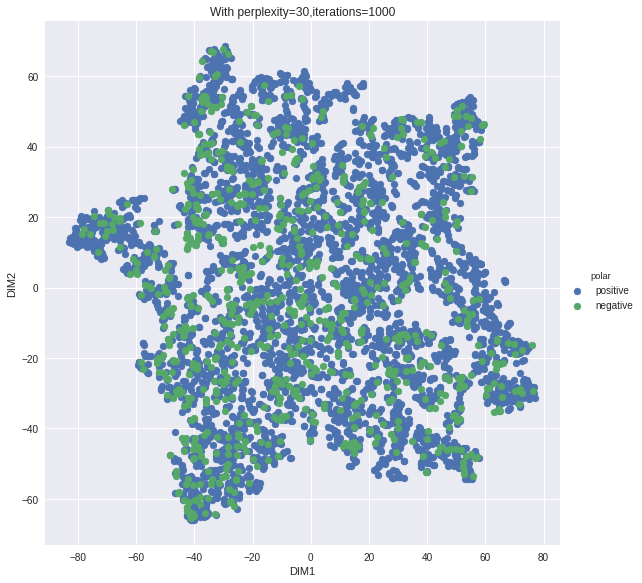

In [0]:
model=TSNE(n_components=2, random_state=0) #setting to default values
tsne_data=model.fit_transform(standardized_data)
tsne_data=np.vstack((tsne_data.T,polar)).T
tsne_df=pd.DataFrame(data=tsne_data, columns=("DIM1", "DIM2", "polar"))
sns.FacetGrid(tsne_df, hue="polar", size=8).map(plt.scatter, 'DIM1', 'DIM2').add_legend()# Ploting the result of tsne
plt.title('With perplexity=30,iterations=1000')
plt.show()

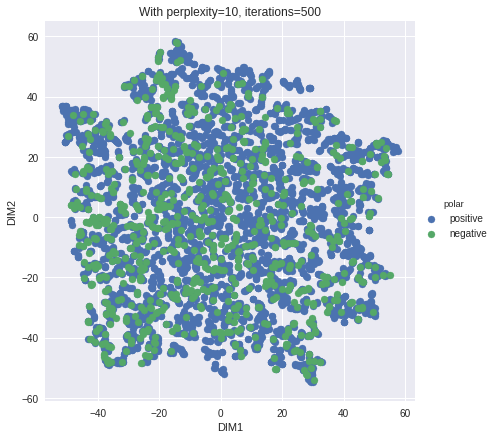

In [0]:
model=TSNE(n_components=2, random_state=0,perplexity=10,n_iter=500)
tsne_data=model.fit_transform(standardized_data)
tsne_data=np.vstack((tsne_data.T,polar)).T # reducing and transforming our features
tsne_df=pd.DataFrame(data=tsne_data, columns=("DIM1","DIM2","polar"))
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter,'DIM1','DIM2').add_legend()# Ploting the result of tsne
plt.title('With perplexity=10, iterations=500')
plt.show()

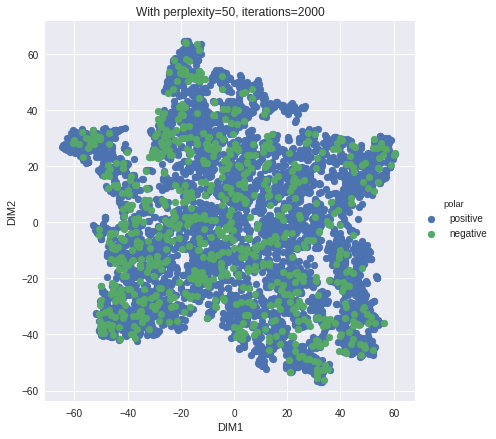

In [0]:
model=TSNE(n_components=2, random_state=0,perplexity=50,n_iter=2000)
tsne_data=model.fit_transform(standardized_data)
tsne_data=np.vstack((tsne_data.T,polar)).T # reducing and transforming our features
tsne_df=pd.DataFrame(data=tsne_data, columns=("DIM1","DIM2","polar"))
sns.FacetGrid(tsne_df, hue="polar", size=6).map(plt.scatter,'DIM1','DIM2').add_legend()# Ploting the result of tsne
plt.title('With perplexity=50, iterations=2000')
plt.show()

**VECTORIZATION TECHNIQUES USED: BAG-of-Words, TF-IDF,Avg W2V, TF-IDF-W2V **

**Conclusions: even with different combinations of perplexities and iterations, we cant able to seperate +ve and -ve reviews**

**Hence, it it better to tryout various models to seperate +ve and -ve reviews in our dataset **